In [161]:
import torch

In [162]:
# Check device availability
device = ''
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
device = torch.device(device)
print("You are using device: %s" % device)

You are using device: mps


In [163]:
DATA_FILE = 'data/sample.csv'
LABELS_OUTPUT = 'data/labels_one_hot.pt'
W2V_EMBEDDED_VISIT_NOTES_OUTPUT = 'data/w2v_embedded_visit_notes.pt'
D2V_EMBEDDED_VISIT_NOTES_OUTPUT = 'data/d2v_embedded_visit_notes.pt'

In [164]:
import pandas as pd

# Printing raw data from data file
df = pd.read_csv(DATA_FILE)
print(df)

       case_num  subject_id icd9_code  \
0             0           0   S8264XJ   
1             0           1   S36501D   
2             0           2   T484X2A   
3             0           3   S86301D   
4             0           4     M9948   
...         ...         ...       ...   
42141         9       95330   S82854H   
42142         9       95331     A1839   
42143         9       95332    M12842   
42144         9       95333   M84522S   
42145         9       95334   O6022X1   

                                                    text  
0      17-year-old male, has come to the student heal...  
1      17 yo male with recurrent palpitations for the...  
2      Dillon Cleveland is a 17 y.o. male patient wit...  
3      a 17 yo m c/o palpitation started 3 mos ago; \...  
4      17yo male with no pmh here for evaluation of p...  
...                                                  ...  
42141  Ms. Madden is a 20 yo female presenting w/ the...  
42142  A 20 YO F CAME COMPLAIN A DU

In [166]:
# Load embedded visit notes
d2v_embedded_visit_notes = torch.load(D2V_EMBEDDED_VISIT_NOTES_OUTPUT, weights_only=True)
w2v_embedded_visit_notes = torch.load(W2V_EMBEDDED_VISIT_NOTES_OUTPUT, weights_only=True)
labels = torch.load(LABELS_OUTPUT, weights_only=True)
print(d2v_embedded_visit_notes.shape)
print(w2v_embedded_visit_notes.shape)
print(labels.shape)

D2V_VECTOR_SIZE = d2v_embedded_visit_notes.shape[1]
W2V_VECTOR_SIZE = w2v_embedded_visit_notes.shape[1]

torch.Size([42146, 128])
torch.Size([42146, 100, 700])
torch.Size([42146, 31882])


In [167]:
embedded_visit_notes = [(d2v, w2v) for d2v, w2v in zip(d2v_embedded_visit_notes, w2v_embedded_visit_notes)]

In [168]:
import importlib
import utils
import numpy as np
from torch.utils.data import DataLoader

importlib.reload(utils)

from utils import ICD9_Dataset


percentage = 0.25
batch_size = 50

num_samples = int(np.floor(percentage * labels.shape[0]))
train_samples = int(np.floor(0.7 * num_samples))
leftovers = num_samples - train_samples
valid_samples = train_samples + int(np.floor(0.5*leftovers))

print("Total Samples: ", str(num_samples))
print("Train Samples: ", str(train_samples))
print("Valid Samples: ", str(valid_samples - train_samples))
print("Test Samples: ", str(num_samples - valid_samples))


# Initialize Dataset
train_dataset = ICD9_Dataset(embedded_visit_notes[:train_samples],
                              labels[:train_samples])
valid_dataset = ICD9_Dataset(embedded_visit_notes[train_samples:valid_samples],
                            labels[train_samples:valid_samples])
test_dataset = ICD9_Dataset(embedded_visit_notes[valid_samples:num_samples],
                              labels[valid_samples:num_samples])

# Initialize DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

Total Samples:  10536
Train Samples:  7375
Valid Samples:  1580
Test Samples:  1581


In [169]:
sample_set = embedded_visit_notes[0:5]
sample_set_d2v, sample_set_w2v = zip(*sample_set)
sample_set_d2v = torch.stack(sample_set_d2v)  
sample_set_w2v = torch.stack(sample_set_w2v)
print(sample_set_d2v.shape)
print(sample_set_w2v.shape)

torch.Size([5, 128])
torch.Size([5, 100, 700])


In [170]:
# Use CNN to process sample set of vector

import importlib
import cnn 

importlib.reload(cnn)

my_cnn = cnn.CNN(device=device).to(device)

x = sample_set_w2v.to(device)
print(x.shape)

output = my_cnn.forward(x)
print(output.shape)


torch.Size([5, 100, 700])
torch.Size([5, 192])


In [171]:
# Use D2V Linear Layer to process sample set of vector

import importlib
import d2v_fc 

importlib.reload(d2v_fc)

dv2_model = d2v_fc.D2VFullyConnectedLayer(device=device).to(device)

x = sample_set_d2v.to(device)
print(x.shape)

output = dv2_model.forward(x)
print(output.shape)

torch.Size([5, 128])
torch.Size([5, 64])


In [181]:
# Use Combined Model to process sample set of data

import importlib
import icd9_dl_model 

importlib.reload(icd9_dl_model)
model = icd9_dl_model.ICD9DeepLearningModel(device=device, num_labels=labels.shape[1]).to(device)

x = (sample_set_d2v, sample_set_w2v)

output = model.forward(x)
print(output)

tensor([[ 0.1474, -0.4055,  0.0278,  ...,  0.1942, -0.1873,  0.4262],
        [-0.0808, -0.4165, -0.0487,  ...,  0.0950,  0.0559,  0.2320],
        [-0.2836, -0.4150, -0.1208,  ...,  0.3969, -0.0469,  0.2186],
        [ 0.2247, -0.4277,  0.0195,  ...,  0.3544,  0.0761,  0.2229],
        [ 0.1190, -0.4391,  0.2052,  ..., -0.1306,  0.1036,  0.1403]],
       device='mps:0', grad_fn=<LinearBackward0>)


In [182]:
import torch.nn as nn
import torch

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

-----------------------------------
Epoch 1
-----------------------------------


Evaluating: 100%|##########| 32/32 [00:03<00:00,  9.87it/s]


Training Loss: 0.7033. Validation Loss: 0.7008. 
Training Accuracy: 0.7635. Validation Accuracy: 0.7956. 
Training Precision: 0.0000. Validation Precision: 0.0000. 
Training Recall: 0.2359. Validation Recall: 0.2019. 
Training F1: 0.0001. Validation F1: 0.0001. 
-----------------------------------
Epoch 2
-----------------------------------


Evaluating: 100%|##########| 32/32 [00:02<00:00, 14.45it/s]


Training Loss: 0.7033. Validation Loss: 0.7008. 
Training Accuracy: 0.7634. Validation Accuracy: 0.7956. 
Training Precision: 0.0000. Validation Precision: 0.0000. 
Training Recall: 0.2343. Validation Recall: 0.2019. 
Training F1: 0.0001. Validation F1: 0.0001. 
-----------------------------------
Epoch 3
-----------------------------------


Evaluating: 100%|##########| 32/32 [00:02<00:00, 13.80it/s]


Training Loss: 0.7033. Validation Loss: 0.7008. 
Training Accuracy: 0.7635. Validation Accuracy: 0.7957. 
Training Precision: 0.0000. Validation Precision: 0.0000. 
Training Recall: 0.2322. Validation Recall: 0.2031. 
Training F1: 0.0001. Validation F1: 0.0001. 
-----------------------------------
Epoch 4
-----------------------------------


Evaluating: 100%|##########| 32/32 [00:02<00:00, 14.49it/s]


Training Loss: 0.7033. Validation Loss: 0.7008. 
Training Accuracy: 0.7635. Validation Accuracy: 0.7956. 
Training Precision: 0.0000. Validation Precision: 0.0000. 
Training Recall: 0.2369. Validation Recall: 0.2027. 
Training F1: 0.0001. Validation F1: 0.0001. 
-----------------------------------
Epoch 5
-----------------------------------


Evaluating: 100%|##########| 32/32 [00:02<00:00, 14.04it/s]


Training Loss: 0.7033. Validation Loss: 0.7008. 
Training Accuracy: 0.7635. Validation Accuracy: 0.7956. 
Training Precision: 0.0000. Validation Precision: 0.0000. 
Training Recall: 0.2311. Validation Recall: 0.2044. 
Training F1: 0.0001. Validation F1: 0.0001. 
-----------------------------------
Epoch 6
-----------------------------------


Evaluating: 100%|##########| 32/32 [00:02<00:00, 13.61it/s]


Training Loss: 0.7033. Validation Loss: 0.7008. 
Training Accuracy: 0.7634. Validation Accuracy: 0.7957. 
Training Precision: 0.0000. Validation Precision: 0.0000. 
Training Recall: 0.2324. Validation Recall: 0.2040. 
Training F1: 0.0001. Validation F1: 0.0001. 
-----------------------------------
Epoch 7
-----------------------------------


Evaluating: 100%|##########| 32/32 [00:02<00:00, 13.80it/s]


Training Loss: 0.7033. Validation Loss: 0.7008. 
Training Accuracy: 0.7634. Validation Accuracy: 0.7957. 
Training Precision: 0.0000. Validation Precision: 0.0000. 
Training Recall: 0.2323. Validation Recall: 0.2040. 
Training F1: 0.0001. Validation F1: 0.0001. 
-----------------------------------
Epoch 8
-----------------------------------


Evaluating: 100%|##########| 32/32 [00:02<00:00, 13.86it/s]


Training Loss: 0.7033. Validation Loss: 0.7008. 
Training Accuracy: 0.7636. Validation Accuracy: 0.7957. 
Training Precision: 0.0000. Validation Precision: 0.0000. 
Training Recall: 0.2331. Validation Recall: 0.2027. 
Training F1: 0.0001. Validation F1: 0.0001. 
-----------------------------------
Epoch 9
-----------------------------------


Evaluating: 100%|##########| 32/32 [00:02<00:00, 13.46it/s]


Training Loss: 0.7033. Validation Loss: 0.7008. 
Training Accuracy: 0.7634. Validation Accuracy: 0.7956. 
Training Precision: 0.0000. Validation Precision: 0.0000. 
Training Recall: 0.2331. Validation Recall: 0.2048. 
Training F1: 0.0001. Validation F1: 0.0001. 
-----------------------------------
Epoch 10
-----------------------------------


Evaluating: 100%|##########| 32/32 [00:02<00:00, 13.91it/s]


Training Loss: 0.7033. Validation Loss: 0.7008. 
Training Accuracy: 0.7635. Validation Accuracy: 0.7956. 
Training Precision: 0.0000. Validation Precision: 0.0000. 
Training Recall: 0.2392. Validation Recall: 0.2052. 
Training F1: 0.0001. Validation F1: 0.0001. 


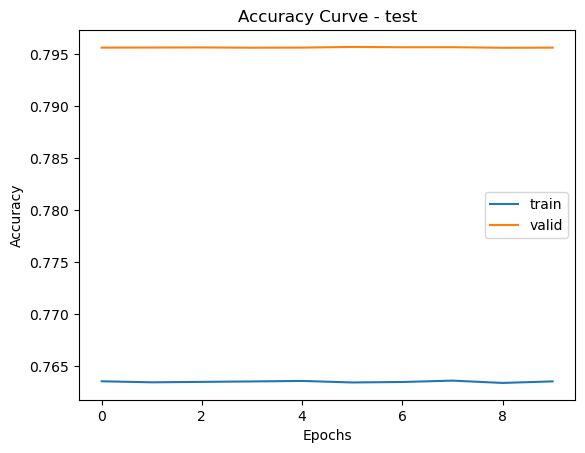

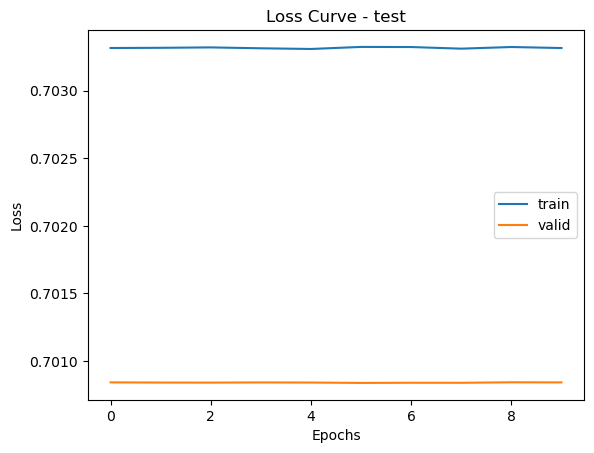

In [183]:
import utils
importlib.reload(utils)
import icd9_dl_model 
importlib.reload(icd9_dl_model)

model = icd9_dl_model.ICD9DeepLearningModel(device=device, num_labels=labels.shape[1]).to(device)
THRESHOLD = 0.2


utils.train_and_plot(model, optimizer, scheduler, criterion, train_loader, valid_loader, device, filename='test', epochs=10, threshold=THRESHOLD)